In [2]:
from data.data_reading import data_reading
from data.data_processing import data_processing
from ruspy.estimation.estimation import estimate
from ruspy.estimation.estimation_cost_parameters import create_transition_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.interpolate import interp1d

# Robust decision making

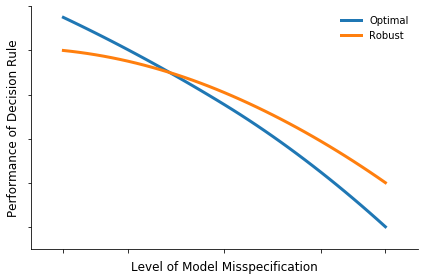

In [8]:
fig, ax = plt.subplots(1, 1)

x_values = [0.00, 0.33, 0.66, 1.00]
y_values = [0.95, 0.70, 0.40, 0.00]

f = interp1d(x_values, y_values, kind='quadratic')
x_grid = np.linspace(0, 1, num=41, endpoint=True)

ax.plot(x_grid, f(x_grid), label='Optimal')

x_values = [0.00, 0.33, 0.66, 1.00]
y_values = [0.80, 0.70, 0.50, 0.20]


f = interp1d(x_values, y_values, kind='quadratic')
x_grid = np.linspace(0, 1, num=41)

ax.plot(x_grid, f(x_grid), label='Robust')

ax.set_xticks((0.0, 0.2, 0.5, 0.8, 1.0))
ax.set_xticklabels([])

ax.yaxis.get_major_ticks()[0].set_visible(False)
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.0)
ax.set_yticklabels([])

ax.set_xlabel('Level of Model Misspecification')
ax.set_ylabel('Performance of Decision Rule')
ax.legend()

plt.savefig('../figures/fig-introduction-robust-performance')

In [2]:
def Kullback_Leibler(p, p_ml):
    """
    This function calculate the Kullback Leibler Divergence of p and p_ml.
    :param p:
    :param p_ml:
    :return:
    """
    return np.sum(np.multiply(p, np.log(np.divide(p, p_ml))))

In [3]:
def create_set(
    p_ml,
    roh,
    step,
    min_grid_p_0,
    min_grid_p_1,
    max_grid_p_0,
    max_grid_p_1,
    set_method="Kullback",
):
    """
    This function evaluates points in a given grid and returns their coordinate if
    they are in the given set.
    :param p_ml: Middle point of set
    :param roh: set size
    :param step: stepsize for grid
    :param min_grid_p_0: minimal value of p_0 in the grid
    :param min_grid_p_1: minimal value of p_1 in the grid
    :param max_grid_p_0: maximal value of p_0 in the grid
    :param max_grid_p_1: maximal value of p_1 in the grid
    :param set_method: Method to calculate distance between probability vectors
    :return:
    """
    if set_method == "Kullback":
        set_cond = Kullback_Leibler
    else:
        raise ValueError("Set measure not supported.")
    set_coordinates = np.empty(shape=(1, 2))
    for p_0 in np.arange(min_grid_p_0, max_grid_p_0, step):
        for p_1 in np.arange(min_grid_p_1, max_grid_p_1, step):
            p = np.array([p_0, p_1, 1 - p_0 - p_1])
            if p[(p > 0) & (p < 1)].size == p.size:
                if roh - Kullback_Leibler(p, p_ml) >= 0:
                    set_coordinates = np.append(set_coordinates, [[p_0, p_1]], axis=0)
    return set_coordinates[1:]

In [4]:
import scipy as sc
p_ml_0 = 0.4
p_ml_1 = 0.25
p_ml_2 = 1 - p_ml_0 - p_ml_1
p_ml = np.array([p_ml_0, p_ml_1, p_ml_2])
rho = 0.06
min_grid_p_0 = min_grid_p_1 = 0
max_grid_p_0 = max_grid_p_1 = 1
step = 0.01
set_probs_pre = create_set(
    p_ml,
    rho,
    step,
    min_grid_p_0,
    min_grid_p_1,
    max_grid_p_0,
    max_grid_p_1,
)
min_grid_p_0 = set_probs_pre[:, 0].min() - step
max_grid_p_0 = set_probs_pre[:, 0].max() + step
min_grid_p_1 = set_probs_pre[:, 1].min() - step
max_grid_p_1 = set_probs_pre[:, 1].max() + step
step = 0.001
set_probs = create_set(
    p_ml,
    rho,
    step,
    min_grid_p_0,
    min_grid_p_1,
    max_grid_p_0,
    max_grid_p_1,
)
hull = sc.spatial.ConvexHull(set_probs)

/home/peisenha/.local/share/anaconda3/envs/ruspy_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/peisenha/.local/share/anaconda3/envs/ruspy_analysis/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


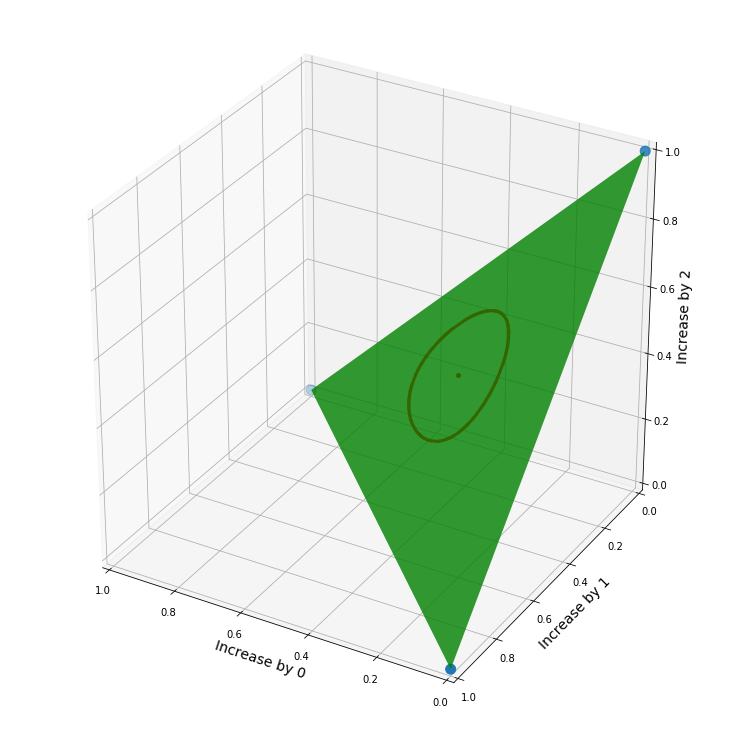

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
verts = [[0, 1, 0], [0, 0, 1], [1, 0, 0]]
ax.set_xlim3d([1, 0])
ax.set_xlabel(r"Increase by 0", fontsize=14)
ax.set_ylim3d([1, 0])
ax.set_ylabel(r"Increase by 1", fontsize=14)
ax.set_zlim3d([0, 1])
ax.set_zlabel(r"Increase by 2", fontsize=14)

ax.scatter(verts[0], verts[1], zs=verts[2], s=100, label="True Position")
for simplex in hull.simplices:
    ax.plot3D(
        set_probs[simplex, 0],
        set_probs[simplex, 1],
        (1 - set_probs[simplex, 0] - set_probs[simplex, 1]),
        color="red",
    )
ax.plot3D([p_ml[0]], [p_ml[1]], [p_ml[2]], marker="o", markersize=4, color="red")
ax.add_collection3d(Poly3DCollection([verts], facecolor="green", alpha=0.8))
plt.savefig("../figures/fig-illustration-simplex.png")
plt.show()

# Calibration of uncertainty set

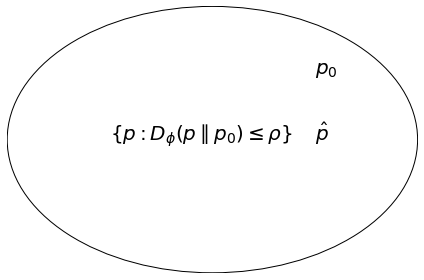

In [6]:
fig, ax = plt.subplots(1, 1)

ax.add_artist(plt.Circle((0, 0), 1, fill=False))

ax.set_ylim([-1, 1])
ax.set_xlim([-1, 1])
ax.axis('off')

plt.annotate(xy=[0.5,0.5], s='$p_0$', fontsize=20)

plt.annotate(xy=[0.5,0], s='$\hat{p}$', fontsize=20)
plt.annotate(xy=[-0.5,0], s=r'$\{p : D_\phi(p \parallel p_0) \leq \rho\}$', fontsize=20)


fig.savefig('{:}/fig-illustration-ambiguity-set-calibration'.format(DIR_FIGURES))